<a href="https://colab.research.google.com/github/hungsvdut2k2/ML_Fundamentals/blob/main/AutoBlurFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np

In [ ]:
image = cv2.imread('/content/283673986_431268301750312_5010638674416825341_n.jpg', 1)

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

In [ ]:
kernel = np.ones((9, 9), np.float32) / 81.0
for (x,y,w,h) in faces:
    image = cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),1)
    roi = image[y : y + h, x : x + w]
    roi = cv2.filter2D(roi, cv2.CV_8U, kernel)
    roi = cv2.filter2D(roi, cv2.CV_8U, kernel)
    roi = cv2.filter2D(roi, cv2.CV_8U, kernel)
    image[y : y + h, x : x + w] = roi

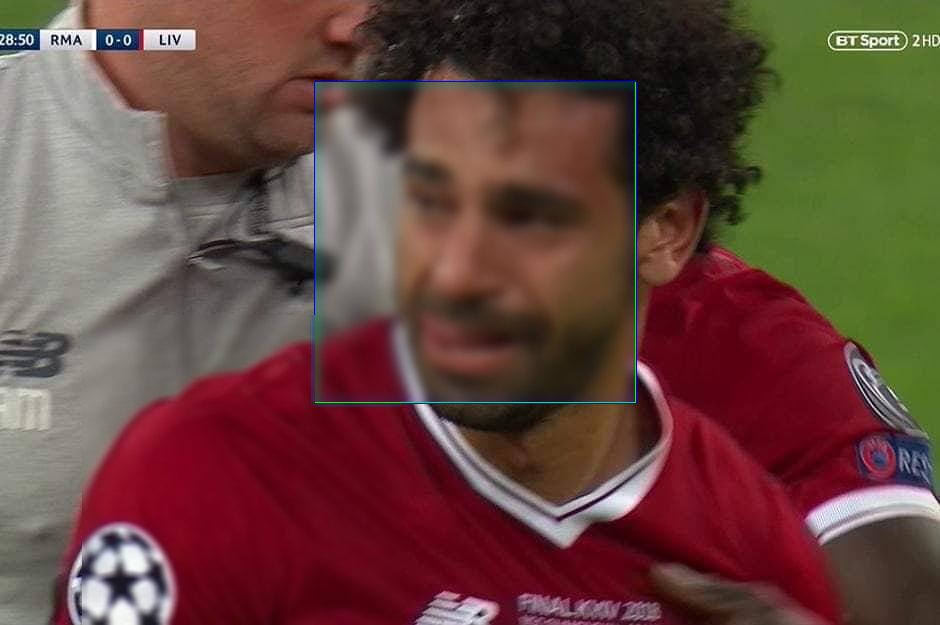

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)